In [1]:
import sys
sys.path.append('../')

import numpy as np

from fmodeling.ForwardProcessing1D import forward_with_trace_calcing
from inversion.Strategies.SeismDiffInversion1D import inverse
from inversion.optimizators.optimizations import LBFGSBOptimization, DifferentialEvolution, TrustKrylov, TrustConstr, \
    ConjugateGradient, AxOptimizer
from Tests.test_ForwardProcessing1D import get_model_2layered, get_model_3layered
from Data.geol_models import get_model_3layered_fluid_rp_dicts
from objects.Data.WavePlaceholder import OWT, WaveDataPlaceholder
from objects.Models.Models import SeismicModel1D
from objects.Attributes.RockPhysics.RockPhysicsAttribute import RockPhysicsAttribute
from objects.Attributes.Seismic.SeismicAttribute import SeismicAttribute
from objects.Models.Layer1D import Layer1D, LayerOPT
import time

from matplotlib import pyplot as plt
from inversion.Strategies.SeismDiffInversion1D import func_to_optimize


In [2]:
def plot_1D_err(forward_params, nvals, min_max=None, dot=False, vline_x=None):
    
    if min_max is None:
        min_val = forward_params['model'].get_optimization_option("min", vectorize=True)
        max_val = forward_params['model'].get_optimization_option("max", vectorize=True)
        
    else:
        min_val = np.array([min_max[0]])
        max_val = np.array([min_max[1]])
    
    dval = (max_val - min_val) / nvals

    val_x = [min_val + dval*i for i in range(nvals+1)]
    errs = []
    for val in val_x:
        errs.append(func_to_optimize(val, placeholders, forward_params, helper=None, show_tol=False))
        
    plt.plot(val_x, errs)
    if dot:
        plt.plot(val_x, errs, 'o')
        
    if vline_x is not None:
        plt.vlines(vline_x, ymin=min(errs), ymax=max(errs), colors='r')
        
    plt.show()

def optimization_func_2D(forward_params, x, y):
    indexes_1 = np.arange(x.shape[0])
    indexes_2 = np.arange(x.shape[1])
    
    Z = np.zeros((x.shape[0], x.shape[1]))
    
    for ind1 in indexes_1:
        for ind2 in indexes_2:
            Z[ind1, ind2] = func_to_optimize([x[ind1, ind2], y[ind1, ind2]], placeholders, forward_params, helper=None, show_tol=False)
        
    return Z

def plot_2D_err(forward_params, nvals, ncontous=10, points=None):
    min_val = forward_params['model'].get_optimization_option("min", vectorize=True)
    max_val = forward_params['model'].get_optimization_option("max", vectorize=True)
    
    dval = (max_val - min_val) / nvals

    val_1_x = [min_val[0] + dval[0]*i for i in range(nvals[0]+1)]
    val_2_x = [min_val[1] + dval[1]*i for i in range(nvals[1]+1)]

    X, Y = np.meshgrid(val_1_x, val_2_x)

    Z = optimization_func_2D(forward_params, X, Y)
    
    plt.contourf(X, Y, Z, ncontous, cmap='seismic')
    plt.colorbar()
    
    if points is not None:
        plt.plot(points[0], points[1], marker='x', color='r')

# Четырехслойная модель с газоосадками

In [3]:
h = [
    67.5,
    22.5,
    20
]

In [4]:
layer_1_seism = {
    'vp': 1500,
    'vs': 700,
    'rho': 1000
}

layer_2_rp = {
    "name": "unconsolidated",
    "components": {
                    "Ksi": {
                      "value": 38,
                      "optimize": True,
                      "min": 20,
                      "max": 40
                    },
					"Gsi": {
                      "value": 44,
                      "optimize": True,
                      "min": 30,
                      "max": 50
                    },
					"rhosi": {
                      "value": 2.2,
                      "optimize": True,
                      "min": 2,
                      "max": 2.5
                    },
                    "Ksh": {
                      "value": 21.5,
                      "optimize": True,
                      "min": 20,
                      "max": 30
                    },
					"Gsh": {
                      "value": 7,
                      "optimize": True,
                      "min": 5,
                      "max": 15
                    },
					"rhosh": {
                      "value": 2.43,
                      "optimize": True,
                      "min": 2,
                      "max": 2.5
                    },
                    "Kincl": {
                      "value": 36.9,
                      "optimize": False,
                      "min": 35,
                      "max": 40
                    },
                    "Gincl": {
                      "value": 31,
                      "optimize": False,
                      "min": 30,
                      "max": 35
                    },
                    "rhoincl": {
                      "value": 2.2,
                      "optimize": False,
                      "min": 2,
                      "max": 2.5
                    },
                    "Kfl": {
                      "value": 2.29,
                      "optimize": False,
                      "min": 0.5,
                      "max": 5
                    },
                    "rhofl": {
                      "value": 1,
                      "optimize": False,
                      "min": 0.5,
                      "max": 1.5
                    },
#                     "Vsi": {
#                       "value": 0.01,
#                       "optimize": False,
#                       "min": 0.5,
#                       "max": 0.99
#                     },
                    "Vsh": {
                      "value": 0.7,
                      "optimize": True,
                      "min": 0.5,
                      "max": 0.99
                    },
                    "Vincl": {
                      "value": 0,
                      "optimize": False,
                      "min": 0.5,
                      "max": 0.99
                    },
                    "phi": {
                      "value": 0.74,
                      "optimize": True,
                      "min": 0.5,
                      "max": 0.99
                    }
                  }
}

layer_3_seism = {
    'vp': 2000,
    'vs': 1000,
    'rho': 2070
}

# посмотреть в дипломе Машки!
layer_4_seism = {
    'vp': 6600,
    'vs': 3600,
    'rho': 2600,
}

In [5]:
layer_1 = Layer1D(h[0],
                  rp_attribute=None,
                  seism_attribute=SeismicAttribute(**layer_1_seism),
                  opt=LayerOPT.NO)
layer_2 = Layer1D(h[1],
                  rp_attribute=RockPhysicsAttribute(layer_2_rp['components'], layer_2_rp['name']),
                  seism_attribute=None,
                  opt=LayerOPT.RP)
layer_3 = Layer1D(h[2],
                  rp_attribute=None,
                  seism_attribute=SeismicAttribute(**layer_3_seism),
                  opt=LayerOPT.NO)
layer_4 = Layer1D(-1,
                  rp_attribute=None,
                  seism_attribute=SeismicAttribute(**layer_4_seism),
                  opt=LayerOPT.NO)

In [6]:
model = SeismicModel1D([layer_1, layer_2, layer_3, layer_4])

In [7]:
# Многоканальная коса

In [8]:
dx = 2
nx = 100
x_rec = [i * dx for i in range(1, nx+1)]
wave_types = [OWT.PdPu_water]
dt = 1e-04
tracelen = 2000

# Forward modeling

Calculating rockphysics model...
Rockphysics model calculated!
Calculating PdPu_water-rays...


/home/apenkin/workspace/rpsi_proj/rpsi/fmodeling/seismic/dynamic/bounds.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  angles[idx])


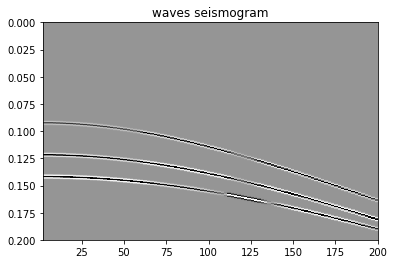

In [9]:
observe, test_seismic = \
    forward_with_trace_calcing(model, x_rec,
                               dt=dt, trace_len=tracelen, wavetypes=wave_types, display_stat=True,
        visualize_res=False, visualize_seismograms=True)

In [10]:
true_vals = model.get_optimization_option('val')

In [11]:
true_vals

OrderedDict([(1,
              {'Ksi': 38,
               'Gsi': 44,
               'rhosi': 2.2,
               'Ksh': 21.5,
               'Gsh': 7,
               'rhosh': 2.43,
               'Vsh': 0.7,
               'phi': 0.74})])

In [12]:
model.layers[0].seism_attribute.vals_dict

{'vp': 1500, 'vs': 700, 'rho': 1000}

In [13]:
model.layers[1].seism_attribute.vals_dict

{'vp': 1534.1089459244965, 'vs': 200.08822703140874, 'rho': 1353.8600000000001}

# Inversion

In [14]:
forward_params = {
    "model": model,
    "x_rec": x_rec,
    "dt": dt,
    "trace_len": tracelen,
    "wavetypes": wave_types,
    "display_stat": False,
    "visualize_res": False
}

In [15]:
placeholders = {}
for wt in wave_types:
    placeholders[wt] = WaveDataPlaceholder(
        wt,
        test_seismic[wt]["rays"],
        test_seismic[wt]["seismogram"]
    )

In [16]:
optimizers_de = [
    DifferentialEvolution(
          popsize= 5,
          maxiter= 50000,
          init= "latinhypercube",
          strategy= "best1bin",
          disp= False,
          polish= False,
          tol= 0.00001,
          mutation= 1.5,
          recombination= 0.6,
          workers= 8
    )
]

In [17]:
optimizers_lbfgs = [
    LBFGSBOptimization(
        maxiter=15000,
        maxfun=15000,
#         factr=10000,
#         maxls=50,
#         epsilon=0.000001
    )
]

In [18]:
optimizers_ax = [
    AxOptimizer(num_evals=20, log_scale=True)
]

In [51]:
min_vals = forward_params['model'].get_optimization_option('min', vectorize=True)
max_vals = forward_params['model'].get_optimization_option('max', vectorize=True)
start_vals = np.random.uniform(min_vals, max_vals)

print(min_vals, max_vals)

[30.  40.   2.  20.   5.   2.   0.5  0.5] [40.   50.    2.5  30.   15.    2.5   0.99  0.99]


In [52]:
start_vals

array([36.17970179, 46.08351848,  2.37773823, 21.87822078,  9.66238172,
        2.21049695,  0.94270364,  0.78960224])

In [53]:
forward_params['model'].set_optimization_option(start_vals)

In [54]:
forward_params['model'].get_optimization_option('val', vectorize=True)

array([36.17970179, 46.08351848,  2.37773823, 21.87822078,  9.66238172,
        2.21049695,  0.94270364,  0.78960224])

In [67]:
func_to_optimize(forward_params['model'].get_optimization_option('val', vectorize=True), placeholders, forward_params, helper=None, show_tol=False)

0.010729592099604062

In [19]:
# scale="minmax"
scale=None
# scale="lg"
start_time = time.time()
inversed_vals = inverse(optimizers_ax, error=0.001, placeholders=placeholders, forward_params=forward_params, scale=scale)
print(f"time: {time.time() - start_time}")

[INFO 10-30 15:43:58] ax.service.utils.dispatch: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 8 arms, GPEI for subsequent arms], generated 0 arm(s) so far). Iterations after 8 will take longer to generate due to model-fitting.
[INFO 10-30 15:43:58] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 10-30 15:43:58] ax.service.managed_loop: Running optimization trial 1...
/home/apenkin/workspace/rpsi_proj/rpsi/fmodeling/seismic/dynamic/bounds.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  angles[idx])
[INFO 10-30 15:43:58] ax.service.managed_loop: Running optimization trial 2...
[INFO 10-30 15:43:58] ax.service.managed_loop: Running optimization trial 3...


0.039295658606055515
0.02044915020075227


[INFO 10-30 15:43:58] ax.service.managed_loop: Running optimization trial 4...
[INFO 10-30 15:43:59] ax.service.managed_loop: Running optimization trial 5...


0.04047913674566064
0.04143072449761298


[INFO 10-30 15:43:59] ax.service.managed_loop: Running optimization trial 6...
[INFO 10-30 15:43:59] ax.service.managed_loop: Running optimization trial 7...


0.025492128012232242
0.049925598402446245


[INFO 10-30 15:43:59] ax.service.managed_loop: Running optimization trial 8...
[INFO 10-30 15:43:59] ax.service.managed_loop: Running optimization trial 9...


0.011898548090748737
0.0450918196674222


/home/apenkin/workspace/rpsi_proj/rpsi/fmodeling/seismic/dynamic/bounds.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  angles[idx])
[INFO 10-30 15:44:02] ax.service.managed_loop: Running optimization trial 10...


0.014974886967248042


/home/apenkin/workspace/rpsi_proj/rpsi/fmodeling/seismic/dynamic/bounds.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  angles[idx])
[INFO 10-30 15:44:05] ax.service.managed_loop: Running optimization trial 11...


0.0119641676648768


/home/apenkin/workspace/rpsi_proj/rpsi/fmodeling/seismic/dynamic/bounds.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  angles[idx])
[INFO 10-30 15:44:08] ax.service.managed_loop: Running optimization trial 12...


0.006197648222716951


/home/apenkin/workspace/rpsi_proj/rpsi/fmodeling/seismic/dynamic/bounds.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  angles[idx])
[INFO 10-30 15:44:11] ax.service.managed_loop: Running optimization trial 13...


0.003515082729511559


/home/apenkin/workspace/rpsi_proj/rpsi/fmodeling/seismic/dynamic/bounds.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  angles[idx])
[INFO 10-30 15:44:14] ax.service.managed_loop: Running optimization trial 14...


0.01077399292004994


/home/apenkin/workspace/rpsi_proj/rpsi/fmodeling/seismic/dynamic/bounds.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  angles[idx])
[INFO 10-30 15:44:18] ax.service.managed_loop: Running optimization trial 15...


0.024366642267080473


/home/apenkin/workspace/rpsi_proj/rpsi/fmodeling/seismic/dynamic/bounds.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  angles[idx])
[INFO 10-30 15:44:21] ax.service.managed_loop: Running optimization trial 16...


0.007182597084657309


/home/apenkin/workspace/rpsi_proj/rpsi/fmodeling/seismic/dynamic/bounds.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  angles[idx])
[INFO 10-30 15:44:25] ax.service.managed_loop: Running optimization trial 17...


0.0007381544121865546


/home/apenkin/workspace/rpsi_proj/rpsi/fmodeling/seismic/dynamic/bounds.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  angles[idx])
[INFO 10-30 15:44:29] ax.service.managed_loop: Running optimization trial 18...


0.00592532529934405


/home/apenkin/workspace/rpsi_proj/rpsi/fmodeling/seismic/dynamic/bounds.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  angles[idx])
[INFO 10-30 15:44:33] ax.service.managed_loop: Running optimization trial 19...


0.0021514199547122484


/home/apenkin/workspace/rpsi_proj/rpsi/fmodeling/seismic/dynamic/bounds.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  angles[idx])
[INFO 10-30 15:44:37] ax.service.managed_loop: Running optimization trial 20...


0.0023342049966310363
0.0022067519217263214
time: 42.30028176307678


/home/apenkin/workspace/rpsi_proj/rpsi/fmodeling/seismic/dynamic/bounds.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  angles[idx])


In [34]:
inversed_vals

[33.629443985509546,
 38.01008739865736,
 2.5,
 20.000000000000004,
 6.241430753035826,
 2.2930277574608233,
 0.6011873880170326,
 0.7268092977056261]

In [33]:
result = {key: {
    "real": val,
    "inversed": inv
} for key, val, inv in zip(true_vals[1].keys(), true_vals[1].values(), inversed_vals)}

In [35]:
result

{'Ksi': {'real': 38, 'inversed': 33.629443985509546},
 'Gsi': {'real': 44, 'inversed': 38.01008739865736},
 'rhosi': {'real': 2.2, 'inversed': 2.5},
 'Ksh': {'real': 21.5, 'inversed': 20.000000000000004},
 'Gsh': {'real': 7, 'inversed': 6.241430753035826},
 'rhosh': {'real': 2.43, 'inversed': 2.2930277574608233},
 'Vsh': {'real': 0.7, 'inversed': 0.6011873880170326},
 'phi': {'real': 0.74, 'inversed': 0.7268092977056261}}

In [ ]:
plot_1D_err(forward_params, 100, vline_x=inversed_model)

In [36]:
func_to_optimize(inversed_vals, placeholders, forward_params, helper=None, show_tol=False)

/home/apenkin/workspace/rpsi_proj/rpsi/fmodeling/seismic/dynamic/bounds.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  angles[idx])


0.0007381544121865546

In [ ]:
res_observe, res_seismic = forward_with_trace_calcing(forward_params['model'], forward_params['x_rec'], 
                           dt=forward_params['dt'], 
                           trace_len=forward_params['trace_len'], 
                           wavetypes=forward_params['wavetypes'],
            display_stat=True, visualize_res=False,
                               visualize_seismograms=True
            )

In [ ]:
diff = test_seismic[OWT.PdPu_water]['seismogram'] - res_seismic[OWT.PdPu_water]['seismogram']

In [ ]:
from Visualization.Seismic import visualize_seismogram


In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

visualize_seismogram(fig, ax, diff, wiggles=False)
